# Problem: Predicting Airplane Delays

Puskar K C


# Project Follow
1. Start a lab.
2. Create a notebook instance and name it "oncloudproject".
3. Increase the used memory to 25 GB from the additional configurations.
4. Open Jupyter Lab and upload this notebook into it.
5. Upload the two combined CVS files (combined_csv_v1.csv and combined_csv_v2.csv), which you created in Part A of this project.

## This file contains the Uploaded CSV file V1 and V2 model fitting and accuracy testing with the required comparision

### Note book created OnCloud Project

### Uploading the compressed file in server and extracting

In [1]:
### Extract Zip Files in AWS One time only.
import zipfile
zip_file_path = 'combined1.zip' 
extracted_dir = 'zipExtract/' 
with zipfile.ZipFile(zip_file_path, 'r') as zip_ref:
    zip_ref.extractall(extracted_dir)

zip_file_path = 'combined2.zip' 
extracted_dir = 'zipExtract/' 
with zipfile.ZipFile(zip_file_path, 'r') as zip_ref:
    zip_ref.extractall(extracted_dir)

### Importing Required Library

In [33]:
# import required Library
import pandas as pd
import numpy as np
import os
import boto3
import sagemaker
from sagemaker.image_uris import retrieve
from sklearn.model_selection import train_test_split
import warnings, requests, zipfile, io
from sagemaker import image_uris
from sagemaker.estimator import Estimator
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score
session = sagemaker.Session()
bucket = session.default_bucket()
region = boto3.Session().region_name
import io
import seaborn as sns

sagemaker.config INFO - Not applying SDK defaults from location: /etc/xdg/sagemaker/config.yaml
sagemaker.config INFO - Not applying SDK defaults from location: /home/ec2-user/.config/sagemaker/config.yaml


In [3]:
df1 = pd.read_csv("zipExtract/combined_csv_v1.csv",low_memory=False)
#df1 = df1.replace({True: 1, False: 0})
df2 = pd.read_csv("zipExtract/combined_csv_v2.csv",low_memory=False)
df2 = df2.replace({True: 1, False: 0})

In [6]:
df1 = df1.replace({True: 1, False: 0})
df1.head()

,target,Distance,Quarter_2,Quarter_3,Quarter_4,Month_2,Month_3,Month_4,Month_5,Month_6,...,DepHourofDay_14,DepHourofDay_15,DepHourofDay_16,DepHourofDay_17,DepHourofDay_18,DepHourofDay_19,DepHourofDay_20,DepHourofDay_21,DepHourofDay_22,DepHourofDay_23
0,0.0,1464.0,0,0,1,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,1.0,1464.0,0,0,1,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,0.0,1464.0,0,0,1,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,0.0,1464.0,0,0,1,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,0.0,1464.0,0,0,1,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


### 1. Split Data into trainng, validation & testing set for CSV Version 1 from Part A for XG Boost

In [58]:
### Split Data into training, Validation & tesing set (70-15-15)% for data 1 version 1
train, test_and_validate = train_test_split(df1, test_size=0.3)
test, validate = train_test_split(test_and_validate, test_size=0.5)
#train_file = 'train.csv'
#test_file = 'test.csv'
#validate_file = 'validate.csv'

In [59]:
X_test = test.drop("target", axis =1)
test_y = test["target"]
directory_path = 'data/v1b'

# Check if the directory exists, and if not, create it
if not os.path.exists(directory_path):
    os.makedirs(directory_path)

#file_path = os.path.join(directory_path, 'train_file')

#with open(file_path, 'w') as file:
 #   file.write('This is some content.')

train.to_csv("data/v1b/train.csv", index = False, header = False)
validate.to_csv("data/v1b/validation.csv", index = False, header = False)
X_test.to_csv("data/v1b/X_test.csv", index = False, header = False)

In [60]:
container = image_uris.retrieve('xgboost', region,version='latest')

INFO:sagemaker.image_uris:Ignoring unnecessary instance type: None.


### Uploading the file into S3 server

In [61]:
### Uploading in AWS S3
prefix = "data_delay/v1b/"
train_path = session.upload_data(path="data/v1b/train.csv", key_prefix=prefix + "input/training")
valid_path = session.upload_data(path="data/v1b/validation.csv", key_prefix=prefix + "input/validation" )
X_test_path = session.upload_data(path="data/v1b/X_test.csv", key_prefix=prefix + "input/test" )

## Checking the path

In [ ]:
print(train_path)
print(valid_path)
print(X_test_path)
print("Files successfully uploaded in AWS SERVER !!!")

## 2 Use xgboost Estimator to build a classification model in CSV v1 data

In [63]:
xgboost_model1 = Estimator(container, 
                              role=sagemaker.get_execution_role(), 
                              instance_count=1, 
                              instance_type='ml.m4.xlarge',
                            output_path='s3://{}/{}v1b/output'.format(bucket,prefix))

sagemaker.config INFO - Not applying SDK defaults from location: /etc/xdg/sagemaker/config.yaml
sagemaker.config INFO - Not applying SDK defaults from location: /home/ec2-user/.config/sagemaker/config.yaml
sagemaker.config INFO - Not applying SDK defaults from location: /etc/xdg/sagemaker/config.yaml
sagemaker.config INFO - Not applying SDK defaults from location: /home/ec2-user/.config/sagemaker/config.yaml


Setting Hyperparameter

In [64]:
### Hyperparameter setting
xgboost_model1.set_hyperparameters(objective='binary:logistic', num_round=20)


In [65]:
training_data_channel = sagemaker.TrainingInput(s3_data=train_path, content_type='text/csv')
validation_data_channel = sagemaker.TrainingInput(s3_data=valid_path, content_type='text/csv')

#### Fitting the Xgboost model

In [66]:
#data_channels7 = {'train': train_channel, 'validation': validate_channel}
xgboost_model1.fit({'train': training_data_channel,'validation': validation_data_channel})

INFO:sagemaker:Creating training-job with name: xgboost-2023-11-04-10-48-07-581


2023-11-04 10:48:07 Starting - Starting the training job...
2023-11-04 10:48:32 Starting - Preparing the instances for training......
2023-11-04 10:49:36 Downloading - Downloading input data......
2023-11-04 10:50:27 Training - Downloading the training image...
2023-11-04 10:50:42 Training - Training image download completed. Training in progress.Arguments: train
[2023-11-04:10:50:59:INFO] Running standalone xgboost training.
[2023-11-04:10:50:59:INFO] File size need to be processed in the node: 257.72mb. Available memory size in the node: 8555.57mb
[2023-11-04:10:50:59:INFO] Determined delimiter of CSV input is ','
[10:50:59] S3DistributionType set as FullyReplicated
[10:51:02] 1144913x93 matrix with 106476909 entries loaded from /opt/ml/input/data/train?format=csv&label_column=0&delimiter=,
[2023-11-04:10:51:02:INFO] Determined delimiter of CSV input is ','
[10:51:02] S3DistributionType set as FullyReplicated
[10:51:03] 245339x93 matrix with 22816527 entries loaded from /opt/ml/input

### 3. Hosting the model in another instance

In [67]:
### Host the Model on another instance
xgb_predictor = xgboost_model1.deploy(initial_instance_count=1,
                serializer = sagemaker.serializers.CSVSerializer(),
                instance_type='ml.m4.xlarge')


INFO:sagemaker:Creating model with name: xgboost-2023-11-04-10-52-21-087
INFO:sagemaker:Creating endpoint-config with name xgboost-2023-11-04-10-52-21-087
INFO:sagemaker:Creating endpoint with name xgboost-2023-11-04-10-52-21-087


------!

### 4 Perform Batch transform and evaluate model on testing Data.

In [68]:
### Perform Batch transform and evaluate model on testing Data.
xgboost_transformer = xgboost_model1.transformer(
    instance_count=1,
    instance_type="ml.m4.xlarge",
    strategy="MultiRecord",
    assemble_with="Line",
    output_path=f"s3://{bucket}/{prefix}output"
)

INFO:sagemaker:Creating model with name: xgboost-2023-11-04-10-55-53-051


# Transforming the test Data

In [69]:
# Transforming the test Data
xgboost_transformer.transform(X_test_path, content_type="text/csv", split_type="Line")
xgboost_transformer.wait()

INFO:sagemaker:Creating transform job with name: xgboost-2023-11-04-10-55-53-628


..................................Arguments: serve
[2023-11-04 11:01:34 +0000] [1] [INFO] Starting gunicorn 19.9.0
[2023-11-04 11:01:34 +0000] [1] [INFO] Listening at: http://0.0.0.0:8080 (1)
[2023-11-04 11:01:34 +0000] [1] [INFO] Using worker: gevent
[2023-11-04 11:01:34 +0000] [21] [INFO] Booting worker with pid: 21
[2023-11-04 11:01:34 +0000] [22] [INFO] Booting worker with pid: 22
[2023-11-04 11:01:34 +0000] [23] [INFO] Booting worker with pid: 23
/opt/amazon/lib/python3.7/site-packages/gunicorn/workers/ggevent.py:65: MonkeyPatchWarning: Monkey-patching ssl after ssl has already been imported may lead to errors, including RecursionError on Python 3.6. It may also silently lead to incorrect behaviour on Python 3.7. Please monkey-patch earlier. See https://github.com/gevent/gevent/issues/1016. Modules that had direct imports (NOT patched): ['urllib3.util.ssl_ (/opt/amazon/lib/python3.7/site-packages/urllib3/util/ssl_.py)', 'urllib3.util (/opt/amazon/lib/python3.7/site-packages/urllib

#### 5. Report the performance metrics that you see better test the model performance 

In [70]:
y_file = boto3.client("s3").get_object(Bucket = bucket, Key = f"{prefix}output/X_test.csv.out")
y_pred = pd.read_csv(io.BytesIO(y_file["Body"].read()), header = None, names = ["Predicted"])

In [71]:
y_pred["actual"] = y_pred["Predicted"].apply(lambda x : 1 if x > 0.5 else 0)

In [72]:
### Calculating Accuracy
accuracy = accuracy_score(test_y, y_pred["actual"])
print("Accuracy:", accuracy)

Accuracy: 0.7905216476860495


### Evaluating the model with the Confusin matrix

[[193657    161]
 [ 51232    288]]


Text(0.5, 1.0, 'Confusion matrix with Accuracy score: 0.7905216476860495')

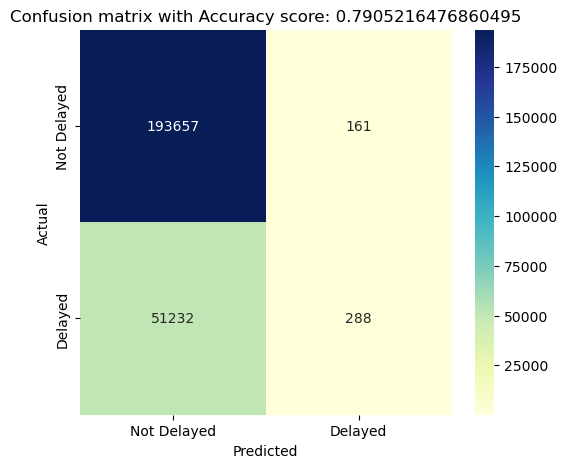

In [73]:
from sklearn.metrics import confusion_matrix
import matplotlib.pyplot as plt
matrix = confusion_matrix(test_y, y_pred["actual"])
df_confusion = pd.DataFrame(matrix, index=['Not Delayed','Delayed'],columns=['Not Delayed','Delayed'])

df_confusion
cm = confusion_matrix(test_y, y_pred["actual"])
print(cm)
plt.figure(figsize=(6,5))
sns.heatmap(cm, annot=True, fmt="d",
cmap="YlGnBu", 
xticklabels=['Not Delayed', 'Delayed'], yticklabels=['Not Delayed', 'Delayed'])
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('Confusion matrix with Accuracy score: {0}'.format(accuracy))


In [74]:
### Find out Accuracy, Precesion, recall & F1- Score after feature engineering
accuracy = accuracy_score(test_y, y_pred["actual"])
precision = precision_score(test_y, y_pred["actual"])
recall = recall_score(test_y, y_pred["actual"])
f1 = f1_score(test_y, y_pred["actual"])
print("Accuracy :", accuracy)
print("Precision :", precision)
print("Recall :", recall)
print("F1-Score :", f1)

Accuracy : 0.7905216476860495
Precision : 0.6414253897550112
Recall : 0.0055900621118012426
F1-Score : 0.01108353056629914


## Working on Version 2 of CSV file created in part 1
### Split Data into trainng, validation & testing set for CSV V2 from Part A for XG Boost

In [36]:
### Split Data into training, Validation & tesing set (70-15-15)% for data 1 version 1
train, test_and_validate = train_test_split(df2, test_size=0.3)
test, validate = train_test_split(test_and_validate, test_size=0.5)
#train_file = 'train.csv'
#test_file = 'test.csv'
#validate_file = 'validate.csv'

In [37]:
X_test = test.drop("target", axis =1)
test_y = test["target"]
directory_path = 'data/v2b'

# Check if the directory exists, and if not, create it
if not os.path.exists(directory_path):
    os.makedirs(directory_path)

#file_path = os.path.join(directory_path, 'train_file')

#with open(file_path, 'w') as file:
 #   file.write('This is some content.')

train.to_csv("data/v2b/train.csv", index = False, header = False)
validate.to_csv("data/v2b/validation.csv", index = False, header = False)
X_test.to_csv("data/v2b/X_test.csv", index = False, header = False)

In [38]:
container = image_uris.retrieve('xgboost', region,version='latest')

INFO:sagemaker.image_uris:Ignoring unnecessary instance type: None.


### Uploading file to AWS server

In [39]:
### Uploading in AWS S3
prefix = "data_delay/v2b/"
train_path = session.upload_data(path="data/v2b/train.csv", key_prefix=prefix + "input/training")
valid_path = session.upload_data(path="data/v2b/validation.csv", key_prefix=prefix + "input/validation" )
X_test_path = session.upload_data(path="data/v2b/X_test.csv", key_prefix=prefix + "input/test" )

Checking the Path

In [ ]:
print(train_path)
print(valid_path)
print(X_test_path)
print("Files successfully uploaded in AWS SERVER !!!")

### 2. Use xgboost estimator to build a classifcation model.

In [41]:
xgboost_model2 = Estimator(container, 
                              role=sagemaker.get_execution_role(), 
                              instance_count=1, 
                              instance_type='ml.m4.xlarge',
                            output_path='s3://{}/{}v2b/output'.format(bucket,prefix))

sagemaker.config INFO - Not applying SDK defaults from location: /etc/xdg/sagemaker/config.yaml
sagemaker.config INFO - Not applying SDK defaults from location: /home/ec2-user/.config/sagemaker/config.yaml
sagemaker.config INFO - Not applying SDK defaults from location: /etc/xdg/sagemaker/config.yaml
sagemaker.config INFO - Not applying SDK defaults from location: /home/ec2-user/.config/sagemaker/config.yaml


In [42]:
### Hyperparameter setting
xgboost_model2.set_hyperparameters(objective='binary:logistic', num_round=20)

In [43]:
training_data_channel = sagemaker.TrainingInput(s3_data=train_path, content_type='text/csv')
validation_data_channel = sagemaker.TrainingInput(s3_data=valid_path, content_type='text/csv')

In [44]:
### Fitting Model
#data_channels7 = {'train': train_channel, 'validation': validate_channel}
xgboost_model2.fit({'train': training_data_channel,'validation': validation_data_channel})

INFO:sagemaker:Creating training-job with name: xgboost-2023-11-04-10-27-40-199


2023-11-04 10:27:40 Starting - Starting the training job...
2023-11-04 10:28:05 Starting - Preparing the instances for training.........
2023-11-04 10:29:17 Downloading - Downloading input data...
2023-11-04 10:29:57 Training - Downloading the training image...
2023-11-04 10:30:37 Training - Training image download completed. Training in progress...Arguments: train
[2023-11-04:10:30:50:INFO] Running standalone xgboost training.
[2023-11-04:10:30:50:INFO] File size need to be processed in the node: 271.17mb. Available memory size in the node: 8547.93mb
[2023-11-04:10:30:50:INFO] Determined delimiter of CSV input is ','
[10:30:50] S3DistributionType set as FullyReplicated
[10:30:52] 1144913x85 matrix with 97317605 entries loaded from /opt/ml/input/data/train?format=csv&label_column=0&delimiter=,
[2023-11-04:10:30:52:INFO] Determined delimiter of CSV input is ','
[10:30:52] S3DistributionType set as FullyReplicated
[10:30:53] 245339x85 matrix with 20853815 entries loaded from /opt/ml/inpu

### 3 Hosting model to another instance

In [46]:
### Host the Model on another instance
xgb_predictor = xgboost_model2.deploy(initial_instance_count=1,
                serializer = sagemaker.serializers.CSVSerializer(),
                instance_type='ml.m4.xlarge')


INFO:sagemaker:Creating model with name: xgboost-2023-11-04-10-32-50-266
INFO:sagemaker:Creating endpoint-config with name xgboost-2023-11-04-10-32-50-266
INFO:sagemaker:Creating endpoint with name xgboost-2023-11-04-10-32-50-266


-----!

### 4. Perform batch transform to evaluate the model on testing data

In [47]:
### Perform Batch transform and evaluate model on testing Data.
xgboost_transformer = xgboost_model2.transformer(
    instance_count=1,
    instance_type="ml.m4.xlarge",
    strategy="MultiRecord",
    assemble_with="Line",
    output_path=f"s3://{bucket}/{prefix}output"
)

INFO:sagemaker:Creating model with name: xgboost-2023-11-04-10-35-52-094


### Transform the test data

In [48]:

# Transforming the test Data
xgboost_transformer.transform(X_test_path, content_type="text/csv", split_type="Line")
xgboost_transformer.wait()

INFO:sagemaker:Creating transform job with name: xgboost-2023-11-04-10-36-10-608


.....................................Arguments: serve
[2023-11-04 10:42:24 +0000] [1] [INFO] Starting gunicorn 19.9.0
[2023-11-04 10:42:24 +0000] [1] [INFO] Listening at: http://0.0.0.0:8080 (1)
[2023-11-04 10:42:24 +0000] [1] [INFO] Using worker: gevent
[2023-11-04 10:42:24 +0000] [21] [INFO] Booting worker with pid: 21
[2023-11-04 10:42:24 +0000] [22] [INFO] Booting worker with pid: 22
[2023-11-04 10:42:24 +0000] [23] [INFO] Booting worker with pid: 23
/opt/amazon/lib/python3.7/site-packages/gunicorn/workers/ggevent.py:65: MonkeyPatchWarning: Monkey-patching ssl after ssl has already been imported may lead to errors, including RecursionError on Python 3.6. It may also silently lead to incorrect behaviour on Python 3.7. Please monkey-patch earlier. See https://github.com/gevent/gevent/issues/1016. Modules that had direct imports (NOT patched): ['urllib3.util.ssl_ (/opt/amazon/lib/python3.7/site-packages/urllib3/util/ssl_.py)', 'urllib3.util (/opt/amazon/lib/python3.7/site-packages/url

In [50]:
### Predict the model
y_file = boto3.client("s3").get_object(Bucket = bucket, Key = f"{prefix}output/X_test.csv.out")
y_pred = pd.read_csv(io.BytesIO(y_file["Body"].read()), header = None, names = ["Predicted"])

In [51]:
y_pred["actual"] = y_pred["Predicted"].apply(lambda x : 1 if x > 0.5 else 0)

### 5. Report the performance metrics that you see better test the model performance 

In [52]:
### Calculating Accuracy
accuracy = accuracy_score(test_y, y_pred["actual"])
print("Accuracy:", accuracy)

Accuracy: 0.8005771629344007


[[191000   2618]
 [ 46308   5412]]


Text(0.5, 1.0, 'Confusion matrix with Accuracy score: 0.8005771629344007')

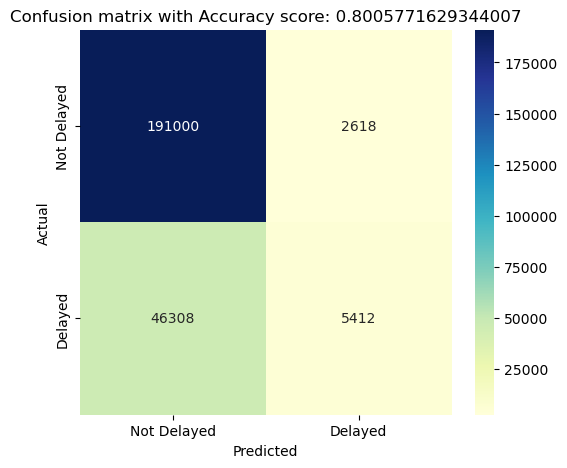

In [53]:
from sklearn.metrics import confusion_matrix
import matplotlib.pyplot as plt
matrix = confusion_matrix(test_y, y_pred["actual"])
df_confusion = pd.DataFrame(matrix, index=['Not Delayed','Delayed'],columns=['Not Delayed','Delayed'])

df_confusion

cm = confusion_matrix(test_y, y_pred["actual"])
print(cm)
plt.figure(figsize=(6,5))
sns.heatmap(cm, annot=True, fmt="d",
cmap="YlGnBu", 
xticklabels=['Not Delayed', 'Delayed'], yticklabels=['Not Delayed', 'Delayed'])
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('Confusion matrix with Accuracy score: {0}'.format(accuracy))

In [55]:
### Find out Accuracy, Precesion, recall & F1- Score after feature engineering
accuracy = accuracy_score(test_y, y_pred["actual"])
precision = precision_score(test_y, y_pred["actual"])
recall = recall_score(test_y, y_pred["actual"])
f1 = f1_score(test_y, y_pred["actual"])
print("Accuracy :", accuracy)
print("Precision :", precision)
print("Recall :", recall)
print("F1-Score :", f1)

Accuracy : 0.8005771629344007
Precision : 0.673972602739726
Recall : 0.10464037122969838
F1-Score : 0.1811548117154812


### 6. write down your observation on the difference between the performance of using the simple and ensemble models.
- Ensemble models like XGBOOST is giving more accuracy compared to normal model, and the precision is also high and recall is also good compared to simple methods.

In [75]:
### Linear learner is in another file